<a href="https://colab.research.google.com/github/InbalBolshinsky/multi-modal-mutation-detector/blob/main/notebooks/LungCancer_ClinVar_DataPrep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading the VCF file from ClinVar and extracting it.

In [1]:
import os

# File URL
url = "ftp://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz"

# Check if the file exists
if not os.path.exists("clinvar.vcf.gz"):
    # Download the file
    !wget -O clinvar.vcf.gz {url}
    print("File downloaded.")
else:
    print("File already exists, skipping download.")

# Decompress the file
!gunzip -f clinvar.vcf.gz


--2024-12-21 15:07:49--  ftp://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz
           => ‘clinvar.vcf.gz’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.12, 130.14.250.13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/clinvar/vcf_GRCh38 ... done.
==> SIZE clinvar.vcf.gz ... 105101364
==> PASV ... done.    ==> RETR clinvar.vcf.gz ... done.
Length: 105101364 (100M) (unauthoritative)

clinvar.vcf.gz      100%[===================>] 100.23M  46.3MB/s    in 2.2s    

2024-12-21 15:07:52 (46.3 MB/s) - ‘clinvar.vcf.gz’ saved [105101364]

File downloaded.


Viewing clinvar.vcf head:

In [2]:
!grep "CLNDN=" clinvar.vcf | head

1	66926	3385321	AG	A	.	.	ALLELEID=3544463;CLNDISDB=Human_Phenotype_Ontology:HP:0000547,MONDO:MONDO:0019200,MeSH:D012174,MedGen:C0035334,OMIM:268000,OMIM:PS268000,Orphanet:791;CLNDN=Retinitis_pigmentosa;CLNHGVS=NC_000001.11:g.66927del;CLNREVSTAT=criteria_provided,_single_submitter;CLNSIG=Uncertain_significance;CLNVC=Deletion;CLNVCSO=SO:0000159;GENEINFO=OR4F5:79501;MC=SO:0001627|intron_variant;ORIGIN=0
1	69134	2205837	A	G	.	.	ALLELEID=2193183;CLNDISDB=MedGen:CN169374;CLNDN=not_specified;CLNHGVS=NC_000001.11:g.69134A>G;CLNREVSTAT=criteria_provided,_single_submitter;CLNSIG=Likely_benign;CLNVC=single_nucleotide_variant;CLNVCSO=SO:0001483;GENEINFO=OR4F5:79501;MC=SO:0001583|missense_variant;ORIGIN=1
1	69314	3205580	T	G	.	.	ALLELEID=3374047;CLNDISDB=MedGen:CN169374;CLNDN=not_specified;CLNHGVS=NC_000001.11:g.69314T>G;CLNREVSTAT=criteria_provided,_single_submitter;CLNSIG=Uncertain_significance;CLNVC=single_nucleotide_variant;CLNVCSO=SO:0001483;GENEINFO=OR4F5:79501;MC=SO:0001583|missense_variant;

Install Required Libraries and Import Modules

In [3]:
# Install necessary libraries
!pip install pysam

# Import required modules
import pysam
import pandas as pd
import os


Load the VCF File into a DataFrame

In [4]:
vcf_file = "clinvar.vcf"
columns = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"]

# Use Pandas to read the VCF file
df = pd.read_csv(vcf_file, sep="\t", comment='#', names=columns, dtype={'CHROM': str}, low_memory=False)

Parse the INFO Field

In [5]:
# Parse INFO column into separate key-value pairs
def parse_info(info):
    parsed = {}
    for entry in info.split(";"):
        if "=" in entry:
            key, value = entry.split("=", 1)
            parsed[key] = value
    return parsed

# Apply parse_info to the INFO column
df["INFO"] = df["INFO"].apply(parse_info)

# Expand parsed INFO into separate columns
info_df = pd.DataFrame(df["INFO"].tolist(), index=df.index)
df = pd.concat([df.drop(columns=["INFO"]), info_df], axis=1)

In [6]:
info_df.head()

,ALLELEID,CLNDISDB,CLNDN,CLNHGVS,CLNREVSTAT,CLNSIG,CLNVC,CLNVCSO,GENEINFO,MC,...,ONCDN,ONCREVSTAT,SCI,SCIREVSTAT,DBVARID,SCIDISDB,SCIDN,ONCDISDBINCL,ONCDNINCL,ONCINCL
0,3544463,"Human_Phenotype_Ontology:HP:0000547,MONDO:MOND...",Retinitis_pigmentosa,NC_000001.11:g.66927del,"criteria_provided,_single_submitter",Uncertain_significance,Deletion,SO:0000159,OR4F5:79501,SO:0001627|intron_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2193183,MedGen:CN169374,not_specified,NC_000001.11:g.69134A>G,"criteria_provided,_single_submitter",Likely_benign,single_nucleotide_variant,SO:0001483,OR4F5:79501,SO:0001583|missense_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3374047,MedGen:CN169374,not_specified,NC_000001.11:g.69314T>G,"criteria_provided,_single_submitter",Uncertain_significance,single_nucleotide_variant,SO:0001483,OR4F5:79501,SO:0001583|missense_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3374048,MedGen:CN169374,not_specified,NC_000001.11:g.69423G>A,"criteria_provided,_single_submitter",Uncertain_significance,single_nucleotide_variant,SO:0001483,OR4F5:79501,SO:0001583|missense_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2238986,MedGen:CN169374,not_specified,NC_000001.11:g.69581C>G,"criteria_provided,_single_submitter",Uncertain_significance,single_nucleotide_variant,SO:0001483,OR4F5:79501,SO:0001583|missense_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check for Missing Columns and Pre-Filter Data

In [7]:
# Check for missing columns and handle them
if "GENEINFO" not in df.columns:
    print("Warning: GENEINFO column is missing. Please verify the VCF file format.")
    df["GENEINFO"] = None

if "CLNSIG" not in df.columns:
    print("Warning: CLNSIG column is missing. Please verify the VCF file format.")
    df["CLNSIG"] = None

# Pre-filter rows with non-null GENEINFO
df = df[df["GENEINFO"].notna()]

In [8]:
df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,ALLELEID,CLNDISDB,CLNDN,...,ONCDN,ONCREVSTAT,SCI,SCIREVSTAT,DBVARID,SCIDISDB,SCIDN,ONCDISDBINCL,ONCDNINCL,ONCINCL
0,1,66926,3385321,AG,A,.,.,3544463,"Human_Phenotype_Ontology:HP:0000547,MONDO:MOND...",Retinitis_pigmentosa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,69134,2205837,A,G,.,.,2193183,MedGen:CN169374,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,69314,3205580,T,G,.,.,3374047,MedGen:CN169374,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,69423,3205581,G,A,.,.,3374048,MedGen:CN169374,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,69581,2252161,C,G,.,.,2238986,MedGen:CN169374,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Initializing dictionary to store filtered by gene dataFrames and viewing the count for each gene

In [9]:
# Define relevant genes and classifications
genes_of_interest = ["EGFR", "KRAS", "ALK"]
classifications = {
    "Pathogenic/Likely_Pathogenic": ["Pathogenic", "Likely_pathogenic"],
    "Benign/Likely_Benign": ["Benign", "Likely_benign"],
    "VUS": ["Uncertain_significance"]
}

# Initialize dictionary to store filtered DataFrames
filtered_dfs = {}

# Process data for each gene and classification
for gene in genes_of_interest:
    print(f"----------Processing gene: {gene}----------")
    for classification_name, classification_values in classifications.items():
        # Filter data for specific gene and classification
        filtered_df = df[
            (df["GENEINFO"].str.contains(gene, na=False)) &
            (df["CLNSIG"].isin(classification_values))
        ]
        count = len(filtered_df)
        print(f"{gene}_{classification_name.replace(' ', '_')}: {count}")
        # Store the filtered DataFrame in the dictionary
        key = f"{gene}_{classification_name.replace(' ', '_')}"
        filtered_dfs[key] = filtered_df

----------Processing gene: EGFR----------
EGFR_Pathogenic/Likely_Pathogenic: 119
EGFR_Benign/Likely_Benign: 1292
EGFR_VUS: 1407
----------Processing gene: KRAS----------
KRAS_Pathogenic/Likely_Pathogenic: 62
KRAS_Benign/Likely_Benign: 146
KRAS_VUS: 198
----------Processing gene: ALK----------
ALK_Pathogenic/Likely_Pathogenic: 131
ALK_Benign/Likely_Benign: 2458
ALK_VUS: 3432


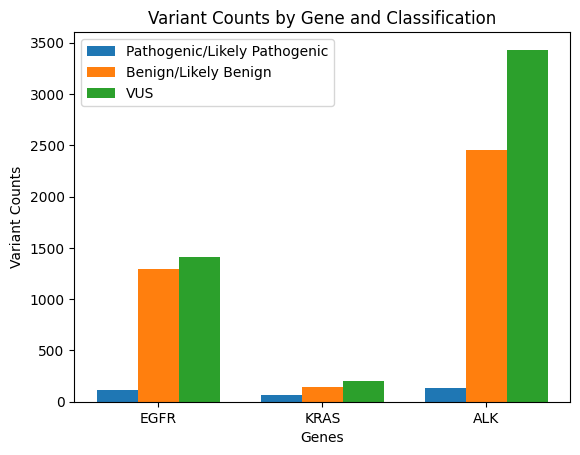

In [10]:
import matplotlib.pyplot as plt

# Data for visualization
genes = ["EGFR", "KRAS", "ALK"]
pathogenic_counts = [119, 62, 131]
benign_counts = [1292, 146, 2458]
vus_counts = [1409, 198, 3432]

# Plotting
bar_width = 0.25
x = range(len(genes))

plt.bar(x, pathogenic_counts, width=bar_width, label="Pathogenic/Likely Pathogenic")
plt.bar([p + bar_width for p in x], benign_counts, width=bar_width, label="Benign/Likely Benign")
plt.bar([p + 2 * bar_width for p in x], vus_counts, width=bar_width, label="VUS")

plt.xticks([p + bar_width for p in x], genes)
plt.xlabel("Genes")
plt.ylabel("Variant Counts")
plt.title("Variant Counts by Gene and Classification")
plt.legend()
plt.show()

Inspecting DataFrames:

In [11]:
for df_name, df in filtered_dfs.items():
    print(f"{df_name}: {len(df)} rows")


EGFR_Pathogenic/Likely_Pathogenic: 119 rows
EGFR_Benign/Likely_Benign: 1292 rows
EGFR_VUS: 1407 rows
KRAS_Pathogenic/Likely_Pathogenic: 62 rows
KRAS_Benign/Likely_Benign: 146 rows
KRAS_VUS: 198 rows
ALK_Pathogenic/Likely_Pathogenic: 131 rows
ALK_Benign/Likely_Benign: 2458 rows
ALK_VUS: 3432 rows


Data summary

Visualization for Null Count and Percentage

============== EGFR_Pathogenic/Likely_Pathogenic Summary ==============

Total rows: 119
Total columns: 39



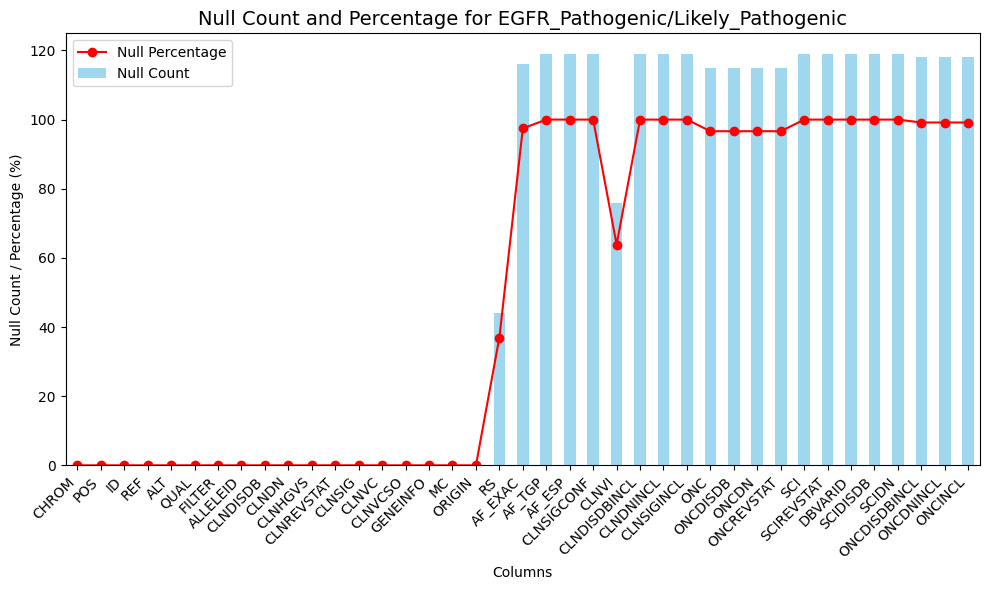

----- Data Preview -----

        CHROM       POS       ID REF ALT QUAL FILTER ALLELEID         CLNDISDB                     CLNDN                     CLNHGVS                           CLNREVSTAT             CLNSIG                      CLNVC     CLNVCSO   GENEINFO                                                                                      MC ORIGIN          RS AF_EXAC AF_TGP AF_ESP CLNSIGCONF CLNVI CLNDISDBINCL CLNDNINCL CLNSIGINCL  ONC ONCDISDB ONCDN ONCREVSTAT  SCI SCIREVSTAT DBVARID SCIDISDB SCIDN ONCDISDBINCL ONCDNINCL ONCINCL
1148453     7  55019367  2855787   T   G    .      .  3010868  MedGen:CN130014  EGFR-related_lung_cancer  NC_000007.14:g.55019367T>G  criteria_provided,_single_submitter  Likely_pathogenic  single_nucleotide_variant  SO:0001483  EGFR:1956                                                         SO:0001575|splice_donor_variant      1         NaN     NaN    NaN    NaN        NaN   NaN          NaN       NaN        NaN  NaN      NaN   NaN        NaN  NaN

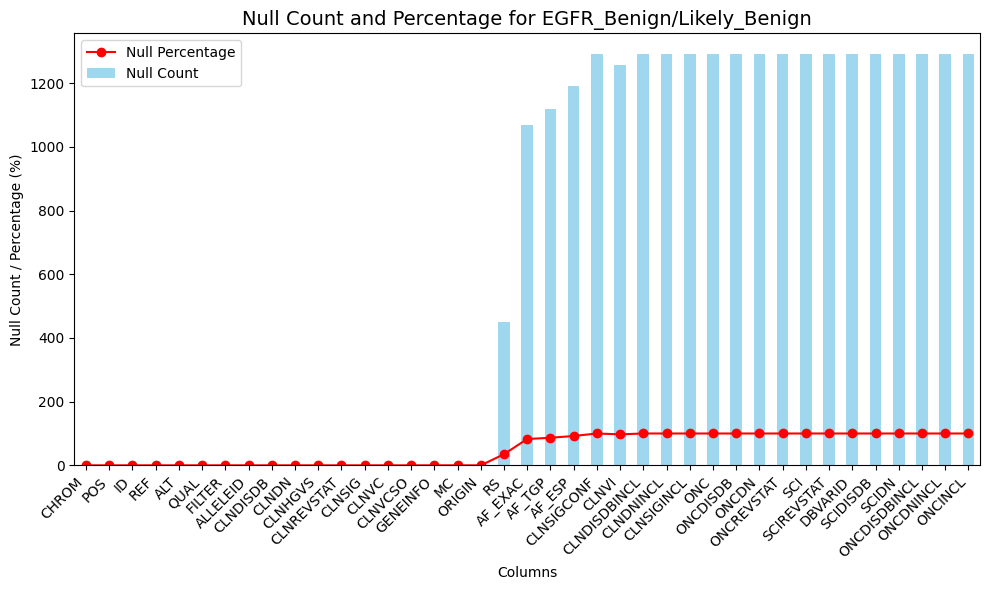

----- Data Preview -----

        CHROM       POS       ID REF ALT QUAL FILTER ALLELEID                             CLNDISDB                     CLNDN                     CLNHGVS                           CLNREVSTAT         CLNSIG                      CLNVC     CLNVCSO   GENEINFO                              MC ORIGIN          RS AF_EXAC   AF_TGP AF_ESP CLNSIGCONF CLNVI CLNDISDBINCL CLNDNINCL CLNSIGINCL  ONC ONCDISDB ONCDN ONCREVSTAT  SCI SCIREVSTAT DBVARID SCIDISDB SCIDN ONCDISDBINCL ONCDNINCL ONCINCL
1148373     7  55018796  1195687   C   A    .      .  1183989                      MedGen:C3661900              not_provided  NC_000007.14:g.55018796C>A  criteria_provided,_single_submitter  Likely_benign  single_nucleotide_variant  SO:0001483  EGFR:1956                             NaN      1    17335710     NaN  0.00439    NaN        NaN   NaN          NaN       NaN        NaN  NaN      NaN   NaN        NaN  NaN        NaN     NaN      NaN   NaN          NaN       NaN     NaN
1148376   

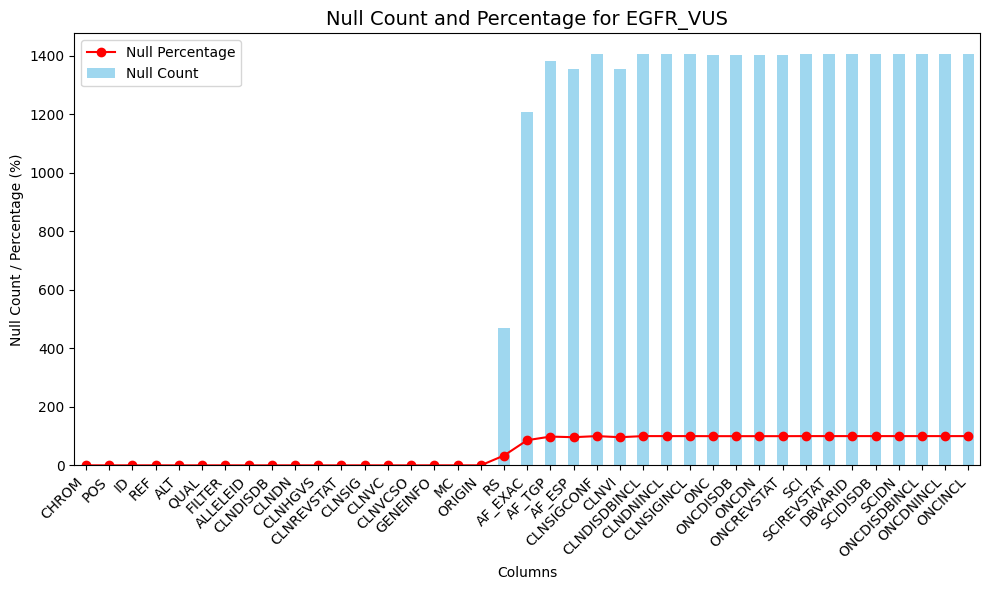

----- Data Preview -----

        CHROM       POS       ID REF ALT QUAL FILTER ALLELEID         CLNDISDB                     CLNDN                     CLNHGVS                           CLNREVSTAT                  CLNSIG                      CLNVC     CLNVCSO   GENEINFO                           MC ORIGIN          RS  AF_EXAC AF_TGP AF_ESP CLNSIGCONF CLNVI CLNDISDBINCL CLNDNINCL CLNSIGINCL  ONC ONCDISDB ONCDN ONCREVSTAT  SCI SCIREVSTAT DBVARID SCIDISDB SCIDN ONCDISDBINCL ONCDNINCL ONCINCL
1148377     7  55019282  1365035   G   A    .      .  1502079  MedGen:CN130014  EGFR-related_lung_cancer  NC_000007.14:g.55019282G>A  criteria_provided,_single_submitter  Uncertain_significance  single_nucleotide_variant  SO:0001483  EGFR:1956  SO:0001583|missense_variant      1  2128853278      NaN    NaN    NaN        NaN   NaN          NaN       NaN        NaN  NaN      NaN   NaN        NaN  NaN        NaN     NaN      NaN   NaN          NaN       NaN     NaN
1148378     7  55019284  1024328   C   G

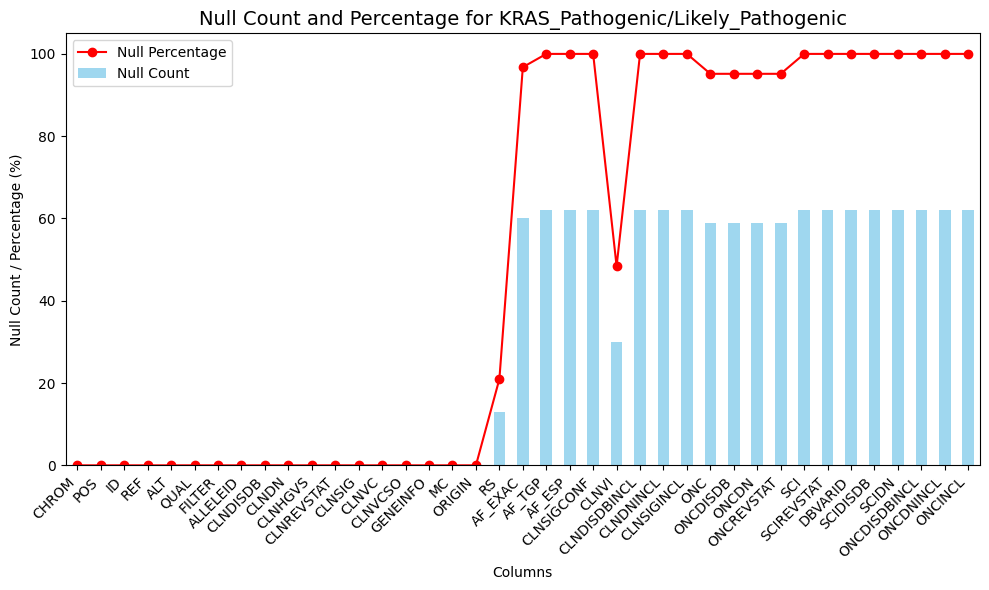

----- Data Preview -----

        CHROM       POS       ID REF ALT QUAL FILTER ALLELEID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

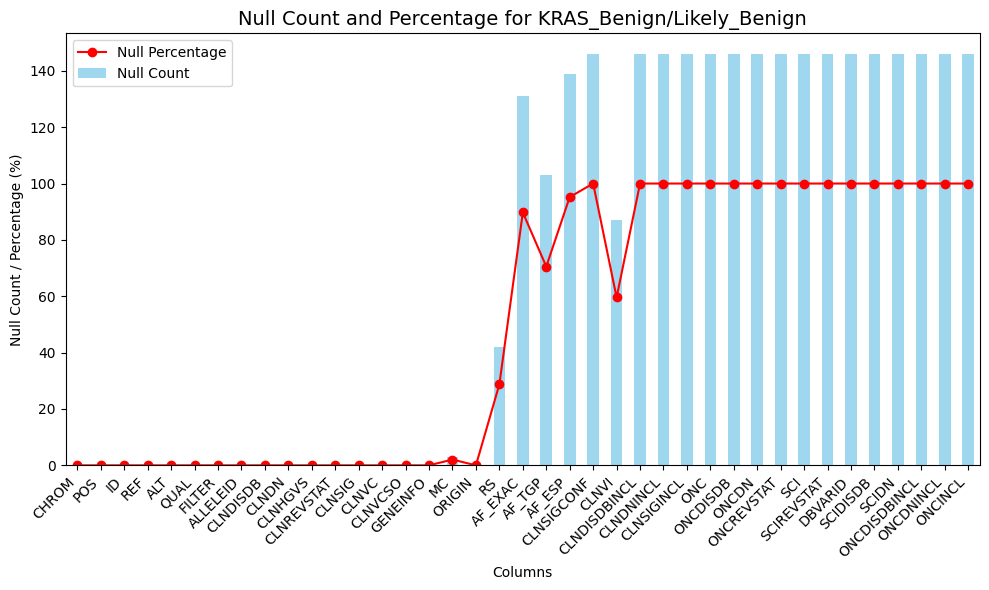

----- Data Preview -----

        CHROM       POS       ID  REF  ALT QUAL FILTER ALLELEID                                                                                                                                     CLNDISDB                                            CLNDN                              CLNHGVS                                            CLNREVSTAT         CLNSIG                      CLNVC     CLNVCSO   GENEINFO                              MC ORIGIN        RS AF_EXAC   AF_TGP AF_ESP CLNSIGCONF               CLNVI CLNDISDBINCL CLNDNINCL CLNSIGINCL  ONC ONCDISDB ONCDN ONCREVSTAT  SCI SCIREVSTAT DBVARID SCIDISDB SCIDN ONCDISDBINCL ONCDNINCL ONCINCL
1814437    12  25205484   308057    T    C    .      .   331606                                                  MONDO:MONDO:0018997,MeSH:D009634,MedGen:C0028326,OMIM:PS163950,Orphanet:648|MedGen:C3661900                     Noonan_syndrome|not_provided           NC_000012.12:g.25205484T>C  criteria_provided,_multiple_submi

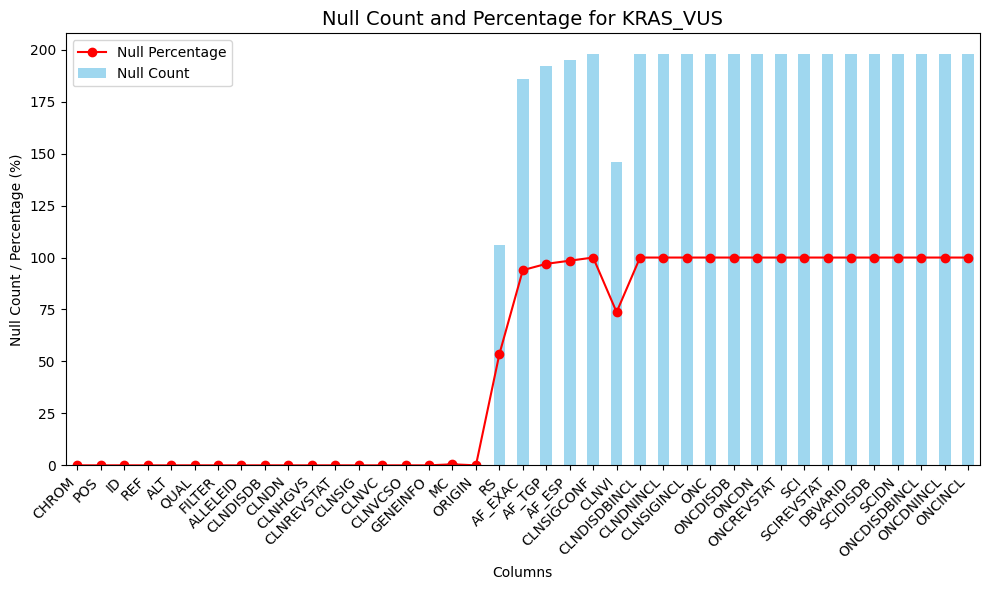

----- Data Preview -----

        CHROM       POS      ID    REF  ALT QUAL FILTER ALLELEID                                                                                                                                     CLNDISDB                                            CLNDN                              CLNHGVS                           CLNREVSTAT                  CLNSIG                      CLNVC     CLNVCSO   GENEINFO                              MC ORIGIN         RS AF_EXAC   AF_TGP AF_ESP CLNSIGCONF               CLNVI CLNDISDBINCL CLNDNINCL CLNSIGINCL  ONC ONCDISDB ONCDN ONCREVSTAT  SCI SCIREVSTAT DBVARID SCIDISDB SCIDN ONCDISDBINCL ONCDNINCL ONCINCL
1814433    12  25205273  308053      C    T    .      .   331599                                                                  MONDO:MONDO:0018997,MeSH:D009634,MedGen:C0028326,OMIM:PS163950,Orphanet:648                                  Noonan_syndrome           NC_000012.12:g.25205273C>T  criteria_provided,_single_submitter  U

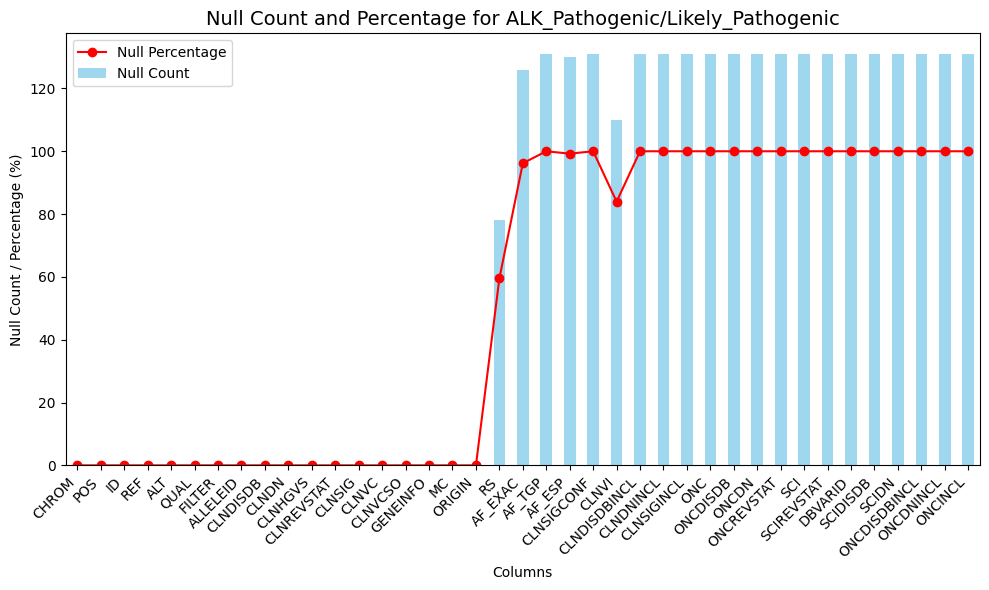

----- Data Preview -----

       CHROM       POS       ID  REF ALT QUAL FILTER ALLELEID                                                                                                                                                                                                                                                        CLNDISDB                                CLNDN                              CLNHGVS                           CLNREVSTAT             CLNSIG                      CLNVC     CLNVCSO GENEINFO                             MC ORIGIN          RS AF_EXAC AF_TGP AF_ESP CLNSIGCONF               CLNVI CLNDISDBINCL CLNDNINCL CLNSIGINCL  ONC ONCDISDB ONCDN ONCREVSTAT  SCI SCIREVSTAT DBVARID SCIDISDB SCIDN ONCDISDBINCL ONCDNINCL ONCINCL
299010     2  29193594  2445362    T   C    .      .  2419088                                                                                                                                                                                   

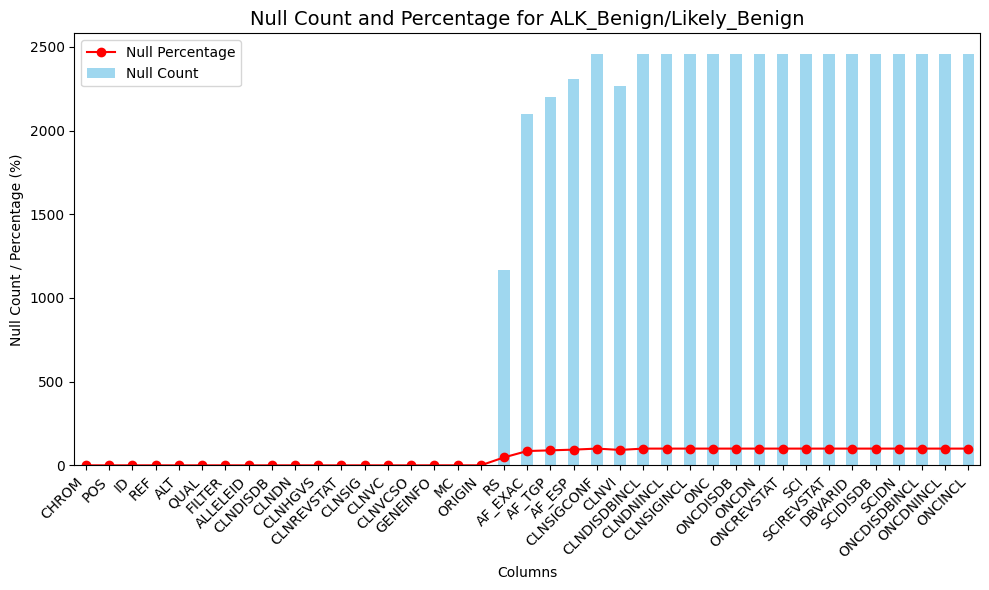

----- Data Preview -----

       CHROM       POS       ID REF    ALT QUAL FILTER ALLELEID                                                                      CLNDISDB                                             CLNDN                              CLNHGVS                                            CLNREVSTAT         CLNSIG                      CLNVC     CLNVCSO       GENEINFO                              MC ORIGIN         RS AF_EXAC   AF_TGP AF_ESP CLNSIGCONF               CLNVI CLNDISDBINCL CLNDNINCL CLNSIGINCL  ONC ONCDISDB ONCDN ONCREVSTAT  SCI SCIREVSTAT DBVARID SCIDISDB SCIDN ONCDISDBINCL ONCDNINCL ONCINCL
268233     2    287736  3111542   C      T    .      .  3268217                                                               MedGen:CN169374                                     not_specified             NC_000002.12:g.287736C>T                   criteria_provided,_single_submitter  Likely_benign  single_nucleotide_variant  SO:0001483  ALKAL2:285016     SO:0001583|missense_varian

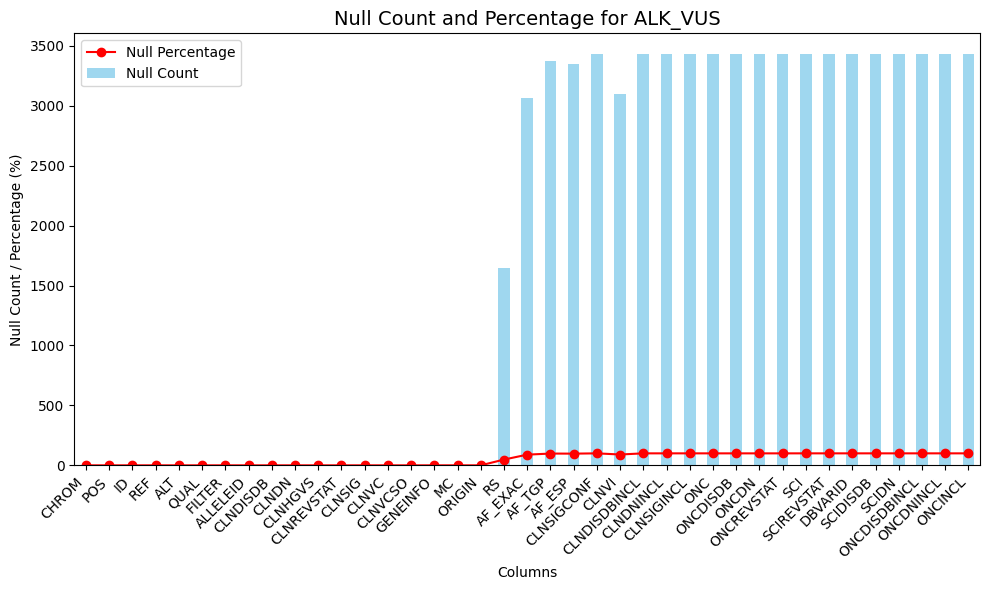

----- Data Preview -----

       CHROM     POS       ID REF ALT QUAL FILTER ALLELEID         CLNDISDB          CLNDN                   CLNHGVS                           CLNREVSTAT                  CLNSIG                      CLNVC     CLNVCSO                              GENEINFO                           MC ORIGIN   RS AF_EXAC AF_TGP AF_ESP CLNSIGCONF CLNVI CLNDISDBINCL CLNDNINCL CLNSIGINCL  ONC ONCDISDB ONCDN ONCREVSTAT  SCI SCIREVSTAT DBVARID SCIDISDB SCIDN ONCDISDBINCL ONCDNINCL ONCINCL
268224     2  283118  3286740   T   G    .      .  3451611  MedGen:CN169374  not_specified  NC_000002.12:g.283118T>G  criteria_provided,_single_submitter  Uncertain_significance  single_nucleotide_variant  SO:0001483                         ALKAL2:285016  SO:0001583|missense_variant      1  NaN     NaN    NaN    NaN        NaN   NaN          NaN       NaN        NaN  NaN      NaN   NaN        NaN  NaN        NaN     NaN      NaN   NaN          NaN       NaN     NaN
268225     2  286153  2551227   G 

In [12]:
import matplotlib.pyplot as plt

# Access and analyze the DataFrames using the dictionary
for df_name, df in filtered_dfs.items():
    # Check if DataFrame is empty
    if df.empty:
        print(f"-------------- {df_name} is Empty ------------------\n")
        continue

    print(f"============== {df_name} Summary ==============\n")

    # General Information
    print(f"Total rows: {len(df)}")
    print(f"Total columns: {len(df.columns)}\n")

    # Null Count and Percentage Visualization
    null_counts = df.isnull().sum()
    null_percentages = (null_counts / len(df)) * 100

    # Bar plot for null counts and percentages
    plt.figure(figsize=(10, 6))
    null_counts.plot(kind='bar', color='skyblue', alpha=0.8, label='Null Count')
    (null_percentages).plot(kind='line', color='red', marker='o', label='Null Percentage')
    plt.title(f"Null Count and Percentage for {df_name}", fontsize=14)
    plt.ylabel("Null Count / Percentage (%)")
    plt.xlabel("Columns")
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # A small preview of the data
    print("----- Data Preview -----\n")
    print(df.head().to_string())  # Show first 5 rows in a clean table-like format
    print("\n")

    print("=" * 50)  # Separator for clarity


identifying null columns, analyzing their significance and dropping the non relevant columns found

In [13]:
for df_name, df in filtered_dfs.items():
    print(f"Columns with 0 non-nulls in {df_name}:")
    print(df.columns[df.isna().all()])
    print(len(df.columns))

Columns with 0 non-nulls in EGFR_Pathogenic/Likely_Pathogenic:
Index(['AF_TGP', 'AF_ESP', 'CLNSIGCONF', 'CLNDISDBINCL', 'CLNDNINCL',
       'CLNSIGINCL', 'SCI', 'SCIREVSTAT', 'DBVARID', 'SCIDISDB', 'SCIDN'],
      dtype='object')
39
Columns with 0 non-nulls in EGFR_Benign/Likely_Benign:
Index(['CLNSIGCONF', 'CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'ONC',
       'ONCDISDB', 'ONCDN', 'ONCREVSTAT', 'SCI', 'SCIREVSTAT', 'DBVARID',
       'SCIDISDB', 'SCIDN', 'ONCDISDBINCL', 'ONCDNINCL', 'ONCINCL'],
      dtype='object')
39
Columns with 0 non-nulls in EGFR_VUS:
Index(['CLNSIGCONF', 'CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SCI',
       'SCIREVSTAT', 'DBVARID', 'SCIDISDB', 'SCIDN', 'ONCDISDBINCL',
       'ONCDNINCL', 'ONCINCL'],
      dtype='object')
39
Columns with 0 non-nulls in KRAS_Pathogenic/Likely_Pathogenic:
Index(['AF_TGP', 'AF_ESP', 'CLNSIGCONF', 'CLNDISDBINCL', 'CLNDNINCL',
       'CLNSIGINCL', 'SCI', 'SCIREVSTAT', 'DBVARID', 'SCIDISDB', 'SCIDN',
       'ONCDISDBINCL', 'ONCDNIN

In [17]:
# Iterate through the dictionary and drop columns with 0 non-null values
for df_name, df in filtered_dfs.items():
    # Drop columns with all NaN values
    filtered_dfs[df_name] = df.dropna(axis=1, how='all')

# Verify the changes
for df_name, df in filtered_dfs.items():
    print(f"After dropping empty columns, {df_name} has {len(df.columns)} columns.")


After dropping empty columns, EGFR_Pathogenic/Likely_Pathogenic has 28 columns.
After dropping empty columns, EGFR_Benign/Likely_Benign has 23 columns.
After dropping empty columns, EGFR_VUS has 27 columns.
After dropping empty columns, KRAS_Pathogenic/Likely_Pathogenic has 25 columns.
After dropping empty columns, KRAS_Benign/Likely_Benign has 23 columns.
After dropping empty columns, KRAS_VUS has 23 columns.
After dropping empty columns, ALK_Pathogenic/Likely_Pathogenic has 22 columns.
After dropping empty columns, ALK_Benign/Likely_Benign has 23 columns.
After dropping empty columns, ALK_VUS has 27 columns.


In [24]:
for df_name, df in filtered_dfs.items():
  print(f"{df_name}: {df.isnull().sum()}")

EGFR_Pathogenic/Likely_Pathogenic: CHROM             0
POS               0
ID                0
REF               0
ALT               0
QUAL              0
FILTER            0
ALLELEID          0
CLNDISDB          0
CLNDN             0
CLNHGVS           0
CLNREVSTAT        0
CLNSIG            0
CLNVC             0
CLNVCSO           0
GENEINFO          0
MC                0
ORIGIN            0
RS               44
AF_EXAC         116
CLNVI            76
ONC             115
ONCDISDB        115
ONCDN           115
ONCREVSTAT      115
ONCDISDBINCL    118
ONCDNINCL       118
ONCINCL         118
dtype: int64
EGFR_Benign/Likely_Benign: CHROM            0
POS              0
ID               0
REF              0
ALT              0
QUAL             0
FILTER           0
ALLELEID         0
CLNDISDB         0
CLNDN            0
CLNHGVS          0
CLNREVSTAT       0
CLNSIG           0
CLNVC            0
CLNVCSO          0
GENEINFO         0
MC               1
ORIGIN           0
RS             451
AF_E

Get all unique columns:

In [25]:
all_columns = set().union(*[set(df.columns) for df in filtered_dfs.values()])
print(all_columns)

{'ALLELEID', 'ORIGIN', 'ONCDN', 'REF', 'CLNVCSO', 'ID', 'CLNHGVS', 'ONC', 'ONCDISDBINCL', 'ONCREVSTAT', 'ONCDISDB', 'CLNDISDB', 'AF_EXAC', 'CLNSIG', 'CLNREVSTAT', 'AF_ESP', 'ALT', 'GENEINFO', 'RS', 'AF_TGP', 'CLNDN', 'CLNVC', 'QUAL', 'FILTER', 'ONCINCL', 'CHROM', 'POS', 'CLNVI', 'MC', 'ONCDNINCL'}


Drop columns if more than 90% of their values are null in any single DataFrame or across all DataFrames.

In [26]:
# Define a null threshold (e.g., 90%)
null_threshold = 0.9

for df_name, df in filtered_dfs.items():
    # Calculate the percentage of null values in each column
    null_percentage = df.isnull().mean()
    # Identify columns exceeding the threshold
    cols_to_drop = null_percentage[null_percentage > null_threshold].index
    # Drop sparse columns
    filtered_dfs[df_name] = df.drop(columns=cols_to_drop)
    print(f"{df_name}: Dropped columns with more then {null_threshold * 100}% nulls: {cols_to_drop.tolist()}")


EGFR_Pathogenic/Likely_Pathogenic: Dropped columns with more then 90.0% nulls: ['AF_EXAC', 'ONC', 'ONCDISDB', 'ONCDN', 'ONCREVSTAT', 'ONCDISDBINCL', 'ONCDNINCL', 'ONCINCL']
EGFR_Benign/Likely_Benign: Dropped columns with more then 90.0% nulls: ['AF_ESP', 'CLNVI']
EGFR_VUS: Dropped columns with more then 90.0% nulls: ['AF_TGP', 'AF_ESP', 'CLNVI', 'ONC', 'ONCDISDB', 'ONCDN', 'ONCREVSTAT']
KRAS_Pathogenic/Likely_Pathogenic: Dropped columns with more then 90.0% nulls: ['AF_EXAC', 'ONC', 'ONCDISDB', 'ONCDN', 'ONCREVSTAT']
KRAS_Benign/Likely_Benign: Dropped columns with more then 90.0% nulls: ['AF_ESP']
KRAS_VUS: Dropped columns with more then 90.0% nulls: ['AF_EXAC', 'AF_TGP', 'AF_ESP']
ALK_Pathogenic/Likely_Pathogenic: Dropped columns with more then 90.0% nulls: ['AF_EXAC', 'AF_ESP']
ALK_Benign/Likely_Benign: Dropped columns with more then 90.0% nulls: ['AF_ESP', 'CLNVI']
ALK_VUS: Dropped columns with more then 90.0% nulls: ['AF_TGP', 'AF_ESP', 'CLNVI', 'ONC', 'ONCDISDB', 'ONCDN', 'ONCREVS

Retain Columns with Sufficient Data Across All DataFrames

In [27]:
# Identify columns present in all DataFrames after dropping sparse columns
common_columns = set.intersection(*[set(df.columns) for df in filtered_dfs.values()])

# Retain only common columns
for df_name, df in filtered_dfs.items():
    filtered_dfs[df_name] = df[list(common_columns)]
    print(f"{df_name}: Retained common columns: {list(common_columns)}")

EGFR_Pathogenic/Likely_Pathogenic: Retained common columns: ['ALLELEID', 'ORIGIN', 'REF', 'CLNVCSO', 'ID', 'CLNHGVS', 'CLNDISDB', 'CLNSIG', 'CLNREVSTAT', 'ALT', 'GENEINFO', 'RS', 'CLNDN', 'CLNVC', 'QUAL', 'FILTER', 'CHROM', 'POS', 'MC']
EGFR_Benign/Likely_Benign: Retained common columns: ['ALLELEID', 'ORIGIN', 'REF', 'CLNVCSO', 'ID', 'CLNHGVS', 'CLNDISDB', 'CLNSIG', 'CLNREVSTAT', 'ALT', 'GENEINFO', 'RS', 'CLNDN', 'CLNVC', 'QUAL', 'FILTER', 'CHROM', 'POS', 'MC']
EGFR_VUS: Retained common columns: ['ALLELEID', 'ORIGIN', 'REF', 'CLNVCSO', 'ID', 'CLNHGVS', 'CLNDISDB', 'CLNSIG', 'CLNREVSTAT', 'ALT', 'GENEINFO', 'RS', 'CLNDN', 'CLNVC', 'QUAL', 'FILTER', 'CHROM', 'POS', 'MC']
KRAS_Pathogenic/Likely_Pathogenic: Retained common columns: ['ALLELEID', 'ORIGIN', 'REF', 'CLNVCSO', 'ID', 'CLNHGVS', 'CLNDISDB', 'CLNSIG', 'CLNREVSTAT', 'ALT', 'GENEINFO', 'RS', 'CLNDN', 'CLNVC', 'QUAL', 'FILTER', 'CHROM', 'POS', 'MC']
KRAS_Benign/Likely_Benign: Retained common columns: ['ALLELEID', 'ORIGIN', 'REF', 'CL

In [28]:
for df_name, df in filtered_dfs.items():
    print(f"{df_name}: Number of columns = {df.shape[1]}")

EGFR_Pathogenic/Likely_Pathogenic: Number of columns = 19
EGFR_Benign/Likely_Benign: Number of columns = 19
EGFR_VUS: Number of columns = 19
KRAS_Pathogenic/Likely_Pathogenic: Number of columns = 19
KRAS_Benign/Likely_Benign: Number of columns = 19
KRAS_VUS: Number of columns = 19
ALK_Pathogenic/Likely_Pathogenic: Number of columns = 19
ALK_Benign/Likely_Benign: Number of columns = 19
ALK_VUS: Number of columns = 19


Identify Columns with Inconsistent Dtypes

In [35]:
from collections import defaultdict

# Dictionary to collect dtypes for each column across DataFrames
column_dtypes = defaultdict(dict)

# Gather dtypes for each column in each DataFrame
for df_name, df in filtered_dfs.items():
    for col in df.columns:
        column_dtypes[col][df_name] = df[col].dtype

# Print inconsistent dtypes
print("\n---- Column Dtype Analysis ----")
for col, dtypes in column_dtypes.items():
    if len(set(dtypes.values())) > 1:  # Check if dtypes differ
        print(f"Column '{col}' has inconsistent dtypes: {dtypes}")



---- Column Dtype Analysis ----


Impute Remaining Null Values:

Numerical columns: Replace null values with the median or mean.
Categorical columns: Replace null values with the mode or a placeholder.

In [36]:
for df_name, df in filtered_dfs.items():
    print(f"\n---- Null Value Imputation for {df_name} ----")
    for col in df.columns:
        if df[col].isnull().sum() > 0:  # Check for null values
            if df[col].dtype in ['float64', 'int64']:  # Numerical columns
                imputation_value = df[col].median()  # Replace with median
                df[col].fillna(imputation_value, inplace=True)
                print(f"Replaced nulls in numerical column '{col}' with median: {imputation_value}")
            else:  # Categorical columns
                imputation_value = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
                df[col].fillna(imputation_value, inplace=True)
                print(f"Replaced nulls in categorical column '{col}' with mode: {imputation_value}")



---- Null Value Imputation for EGFR_Pathogenic/Likely_Pathogenic ----

---- Null Value Imputation for EGFR_Benign/Likely_Benign ----

---- Null Value Imputation for EGFR_VUS ----

---- Null Value Imputation for KRAS_Pathogenic/Likely_Pathogenic ----

---- Null Value Imputation for KRAS_Benign/Likely_Benign ----

---- Null Value Imputation for KRAS_VUS ----

---- Null Value Imputation for ALK_Pathogenic/Likely_Pathogenic ----

---- Null Value Imputation for ALK_Benign/Likely_Benign ----

---- Null Value Imputation for ALK_VUS ----


Data Integrity Validation

In [37]:
print("\n----- Data Integrity Check -----\n")

# Check for duplicates and null counts
for df_name, df in filtered_dfs.items():
    duplicate_count = df.duplicated().sum()
    null_count = df.isnull().sum().sum()
    print(f"{df_name}: {duplicate_count} duplicates, {null_count} total null values.")

# Verify column consistency
columns_list = [df.columns for df in filtered_dfs.values()]
if all(columns.equals(columns_list[0]) for columns in columns_list):
    print("\nAll DataFrames have consistent column structures.")
else:
    print("\nWarning: Inconsistent column structures detected.")



----- Data Integrity Check -----

EGFR_Pathogenic/Likely_Pathogenic: 0 duplicates, 0 total null values.
EGFR_Benign/Likely_Benign: 0 duplicates, 0 total null values.
EGFR_VUS: 0 duplicates, 0 total null values.
KRAS_Pathogenic/Likely_Pathogenic: 0 duplicates, 0 total null values.
KRAS_Benign/Likely_Benign: 0 duplicates, 0 total null values.
KRAS_VUS: 0 duplicates, 0 total null values.
ALK_Pathogenic/Likely_Pathogenic: 0 duplicates, 0 total null values.
ALK_Benign/Likely_Benign: 0 duplicates, 0 total null values.
ALK_VUS: 0 duplicates, 0 total null values.

All DataFrames have consistent column structures.


verify null values:

In [38]:
for df_name, df in filtered_dfs.items():
  print(f"{df_name}:")
  if(df.isnull().sum().sum() == 0):
    print("No null values")
  else:
    print(df.isnull().sum())

EGFR_Pathogenic/Likely_Pathogenic:
No null values
EGFR_Benign/Likely_Benign:
No null values
EGFR_VUS:
No null values
KRAS_Pathogenic/Likely_Pathogenic:
No null values
KRAS_Benign/Likely_Benign:
No null values
KRAS_VUS:
No null values
ALK_Pathogenic/Likely_Pathogenic:
No null values
ALK_Benign/Likely_Benign:
No null values
ALK_VUS:
No null values


Detect and Handle Anomalies

Identify Negative Values (Anomalies):

In [39]:
for df_name, df in filtered_dfs.items():
    print(f"\n---- Anomaly Check for {df_name} ----")
    numeric_cols = df.select_dtypes(include='number').columns
    for col in numeric_cols:
        invalid_values = (df[col] < 0).sum()
        if invalid_values > 0:
            print(f"Column '{col}' has {invalid_values} negative values. Replacing them.")
            median_value = df[col][df[col] >= 0].median()
            df[col] = df[col].apply(lambda x: median_value if x < 0 else x)


---- Anomaly Check for EGFR_Pathogenic/Likely_Pathogenic ----

---- Anomaly Check for EGFR_Benign/Likely_Benign ----

---- Anomaly Check for EGFR_VUS ----

---- Anomaly Check for KRAS_Pathogenic/Likely_Pathogenic ----

---- Anomaly Check for KRAS_Benign/Likely_Benign ----

---- Anomaly Check for KRAS_VUS ----

---- Anomaly Check for ALK_Pathogenic/Likely_Pathogenic ----

---- Anomaly Check for ALK_Benign/Likely_Benign ----

---- Anomaly Check for ALK_VUS ----


Detect and Handle Outliers (IQR Method)

In [43]:
for df_name, df in filtered_dfs.items():
    print(f"\n---- Outlier Detection for {df_name} ----")
    numeric_cols = df.select_dtypes(include='number').columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if not outliers.empty:
            print(f"Column '{col}' has {len(outliers)} outliers. Handling them.")
            df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))



---- Outlier Detection for EGFR_Pathogenic/Likely_Pathogenic ----

---- Outlier Detection for EGFR_Benign/Likely_Benign ----

---- Outlier Detection for EGFR_VUS ----

---- Outlier Detection for KRAS_Pathogenic/Likely_Pathogenic ----

---- Outlier Detection for KRAS_Benign/Likely_Benign ----

---- Outlier Detection for KRAS_VUS ----

---- Outlier Detection for ALK_Pathogenic/Likely_Pathogenic ----

---- Outlier Detection for ALK_Benign/Likely_Benign ----

---- Outlier Detection for ALK_VUS ----


Validate Column Consistency

In [41]:
columns_list = [df.columns for df in filtered_dfs.values()]
if all(columns.equals(columns_list[0]) for columns in columns_list):
    print("\nAll DataFrames now have consistent column structures and dtypes.")
else:
    print("\nWarning: Column inconsistency persists. Investigate further.")



All DataFrames now have consistent column structures and dtypes.


Examine the POS column:

Visualization for Numerical Data:

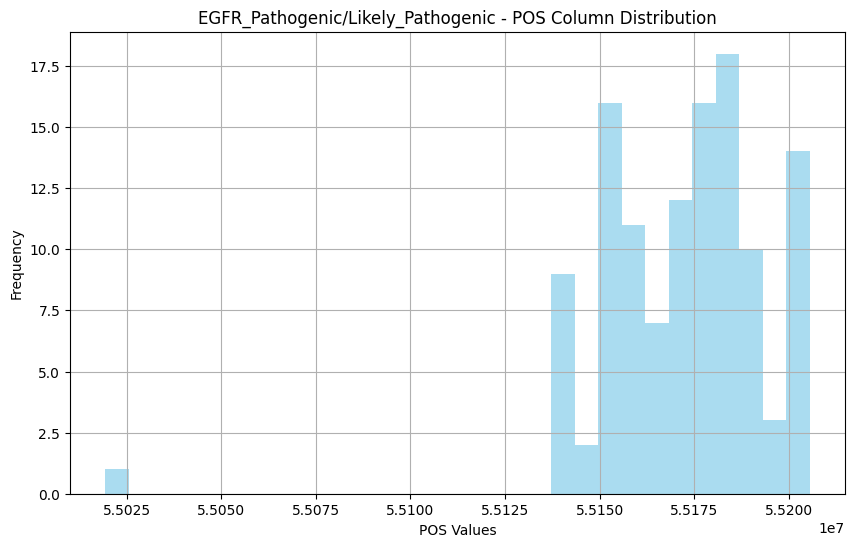

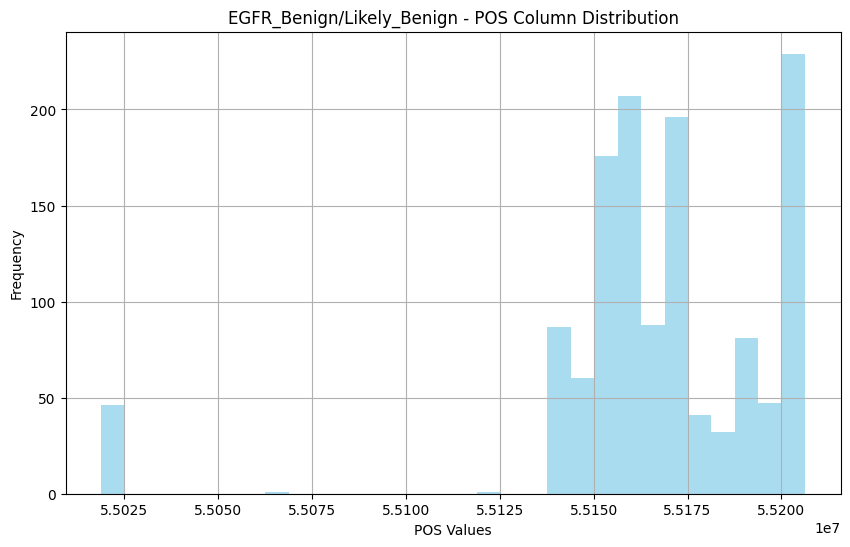

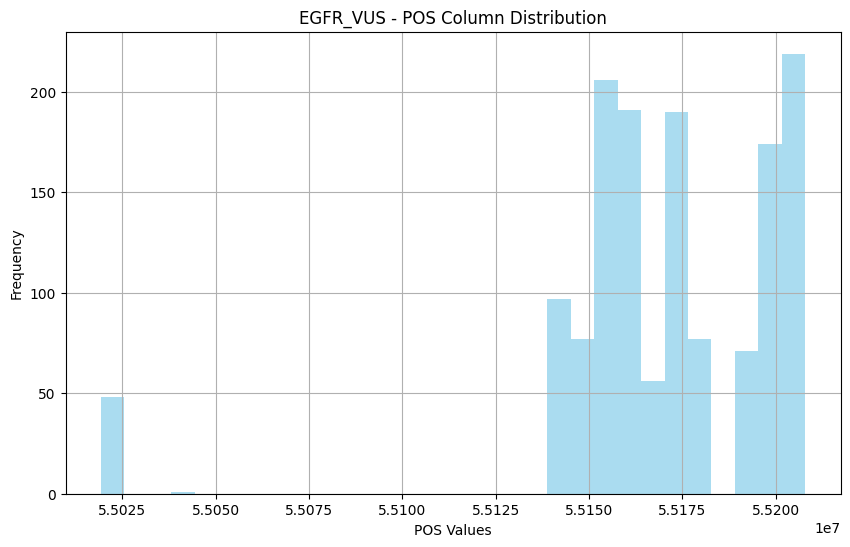

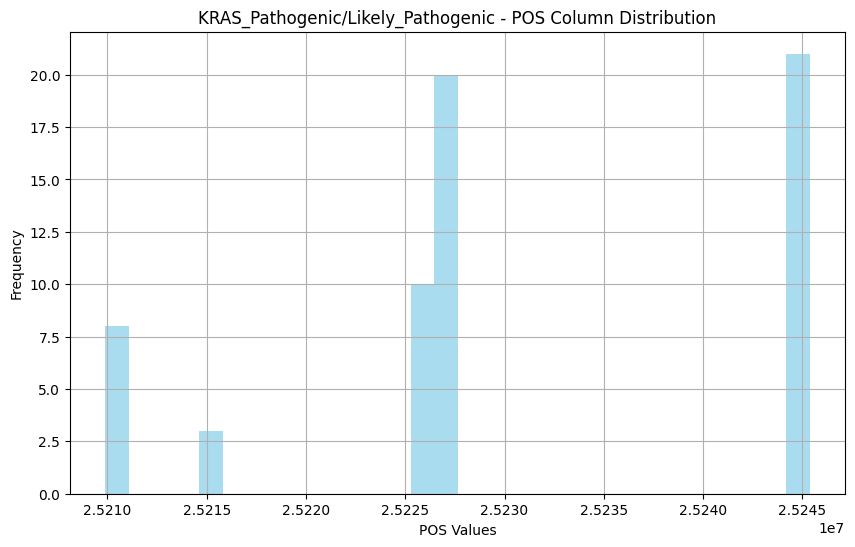

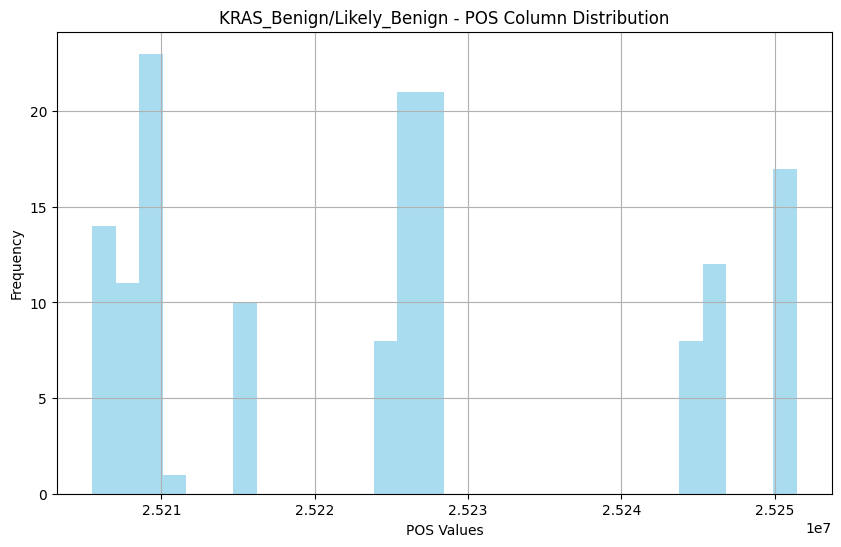

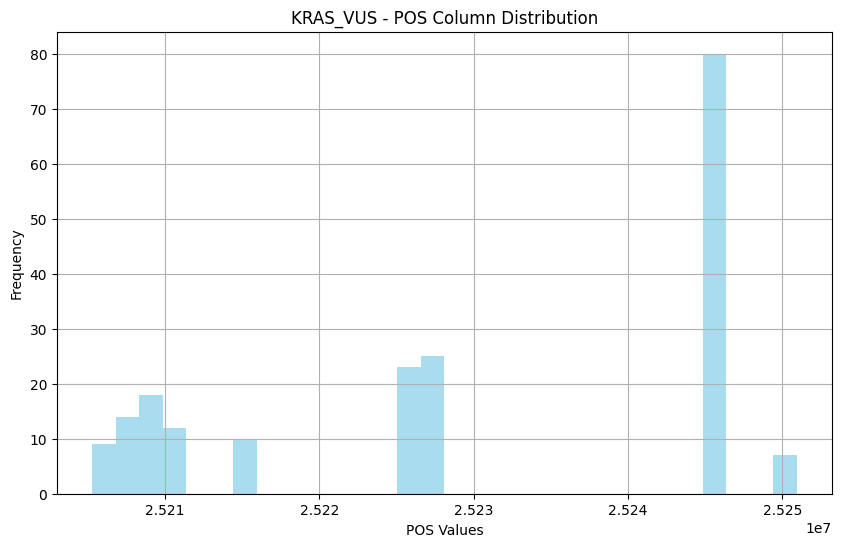

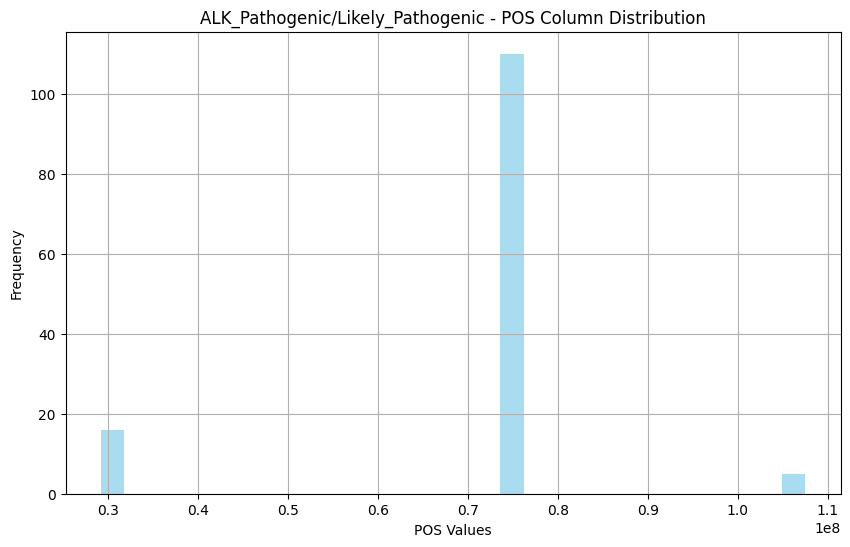

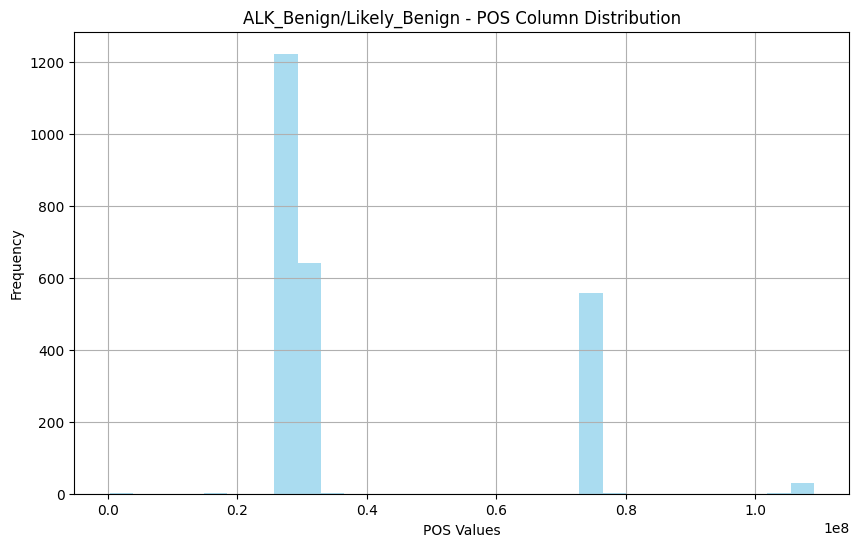

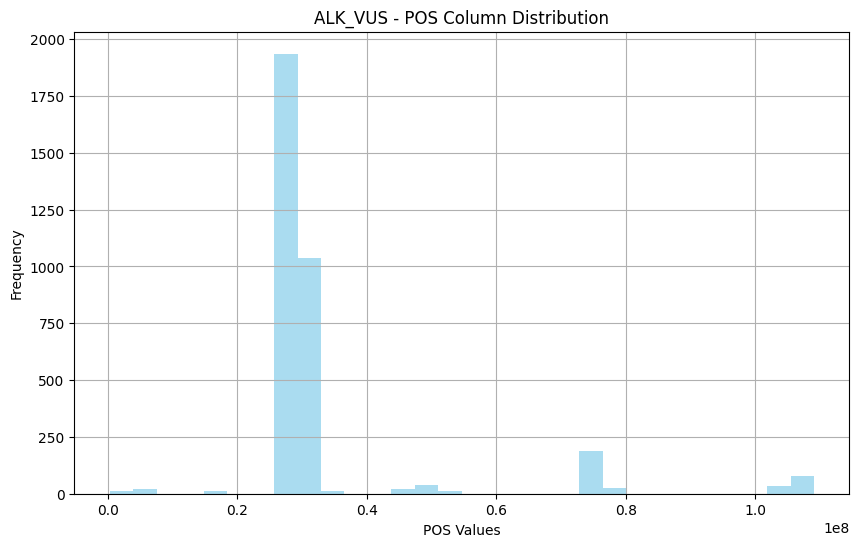

In [40]:
import matplotlib.pyplot as plt

for df_name, df in filtered_dfs.items():
    if 'POS' in df.columns and pd.api.types.is_numeric_dtype(df['POS']):
        plt.figure(figsize=(10, 6))
        df['POS'].hist(bins=30, color='skyblue', alpha=0.7)
        plt.title(f"{df_name} - POS Column Distribution")
        plt.xlabel("POS Values")
        plt.ylabel("Frequency")
        plt.show()


# **Feature selection:**

assure the target value

In [47]:
for df_name, df in filtered_dfs.items():
  print(df['CLNSIG'])

Series([], Name: CLNSIG, dtype: float64)
Series([], Name: CLNSIG, dtype: float64)
Series([], Name: CLNSIG, dtype: float64)
Series([], Name: CLNSIG, dtype: float64)
Series([], Name: CLNSIG, dtype: float64)
Series([], Name: CLNSIG, dtype: float64)
Series([], Name: CLNSIG, dtype: float64)
Series([], Name: CLNSIG, dtype: float64)
Series([], Name: CLNSIG, dtype: float64)


In [48]:
for df_name, df in filtered_dfs.items():
    if 'CLNSIG' in df.columns:
        print(f"\nProcessing CLNSIG column for {df_name}:")

        # Convert to float, handling errors
        df['CLNSIG'] = pd.to_numeric(df['CLNSIG'], errors='coerce')  # Convert safely

        # Check for nulls after conversion
        null_count = df['CLNSIG'].isnull().sum()
        if null_count > 0:
            print(f"Warning: {null_count} null values detected in CLNSIG after conversion.")

            # Drop rows with NaN in CLNSIG
            df.dropna(subset=['CLNSIG'], inplace=True)
            print(f"Dropped {null_count} rows with null values in CLNSIG.")



Processing CLNSIG column for EGFR_Pathogenic/Likely_Pathogenic:

Processing CLNSIG column for EGFR_Benign/Likely_Benign:

Processing CLNSIG column for EGFR_VUS:

Processing CLNSIG column for KRAS_Pathogenic/Likely_Pathogenic:

Processing CLNSIG column for KRAS_Benign/Likely_Benign:

Processing CLNSIG column for KRAS_VUS:

Processing CLNSIG column for ALK_Pathogenic/Likely_Pathogenic:

Processing CLNSIG column for ALK_Benign/Likely_Benign:

Processing CLNSIG column for ALK_VUS:


Compute Correlation with the Target Variable

In [49]:
for df_name, df in filtered_dfs.items():
    print(f"\nProcessing correlation analysis for {df_name}...")

    for col in df.columns:
        # Convert column to numeric, replacing invalid entries with NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

        # Fill NaN (invalid entries) with the median of the column
        if df[col].isnull().any():  # Check if there are any NaN values
            median_value = df[col].median()  # Compute the median
            df[col].fillna(median_value, inplace=True)  # Fill NaN with median
            print(f"Filled invalid entries in column '{col}' with median: {median_value}")

    # Proceed with correlation analysis
    if 'CLNSIG' in df.columns:
        correlations = df.corr()['CLNSIG'].sort_values(ascending=False)
        print(f"\nTop Correlated Features with CLNSIG in {df_name}:")
        print(correlations.head(10))  # Display top 10 correlated features
    else:
        print(f"CLNSIG not found in {df_name}.")



Processing correlation analysis for EGFR_Pathogenic/Likely_Pathogenic...

Top Correlated Features with CLNSIG in EGFR_Pathogenic/Likely_Pathogenic:
ALLELEID     NaN
ORIGIN       NaN
REF          NaN
CLNVCSO      NaN
ID           NaN
CLNHGVS      NaN
CLNDISDB     NaN
CLNSIG       NaN
CLNREVSTAT   NaN
ALT          NaN
Name: CLNSIG, dtype: float64

Processing correlation analysis for EGFR_Benign/Likely_Benign...

Top Correlated Features with CLNSIG in EGFR_Benign/Likely_Benign:
ALLELEID     NaN
ORIGIN       NaN
REF          NaN
CLNVCSO      NaN
ID           NaN
CLNHGVS      NaN
CLNDISDB     NaN
CLNSIG       NaN
CLNREVSTAT   NaN
ALT          NaN
Name: CLNSIG, dtype: float64

Processing correlation analysis for EGFR_VUS...

Top Correlated Features with CLNSIG in EGFR_VUS:
ALLELEID     NaN
ORIGIN       NaN
REF          NaN
CLNVCSO      NaN
ID           NaN
CLNHGVS      NaN
CLNDISDB     NaN
CLNSIG       NaN
CLNREVSTAT   NaN
ALT          NaN
Name: CLNSIG, dtype: float64

Processing correlatio